<a href="https://colab.research.google.com/github/aveexela/HWPS/blob/main/%D1%81%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Робастность методов регрессии

Нелинейная регрессия с различными распределениями ошибок.

## 1. Модель
$f(x, a) = \frac{a_1 x + a_0}{x + a_2}$

Истинные параметры: $a_0=0$, $a_1=1$, $a_2=1$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
np.random.seed(42)

x = np.arange(0.1, 3.01, 0.1)

def f(x, a):
    a0, a1, a2 = a
    return (a1 * x + a0) / (x + a2)

a_true = np.array([0.0, 1.0, 1.0])
y_true = f(x, a_true)

## 2. Генерация погрешностей

In [2]:
sigma = 0.05

def normal_errors():
    return np.random.normal(0, sigma, size=len(x))

def uniform_errors():
    a = np.sqrt(3)*sigma
    return np.random.uniform(-a, a, size=len(x))

def laplace_errors():
    lam = np.sqrt(2)/sigma
    return np.random.laplace(0, 1/lam, size=len(x))


## 3. Функции потерь

In [3]:
def residuals(a, x, y):
    return y - f(x, a)

def loss_ols(a, x, y):
    return np.sum(residuals(a, x, y)**2)

def loss_lad(a, x, y):
    return np.sum(np.abs(residuals(a, x, y)))

def loss_minimax(a, x, y):
    return np.max(np.abs(residuals(a, x, y)))

def estimate(loss, y):
    res = minimize(loss, a_true, args=(x, y))
    return res.x


## 4. Многократное моделирование и дисперсии

In [5]:
def simulate(error_func, loss, M=1000):
    estimates = []
    for _ in range(M):
        y = y_true + error_func()
        estimates.append(estimate(loss, y))
    return np.var(estimates, axis=0)

methods = {
    "OLS": loss_ols,
    "LAD": loss_lad,
    "Minimax": loss_minimax
}

errors = {
    "Normal": normal_errors,
    "Uniform": uniform_errors,
    "Laplace": laplace_errors
}

results = {}
for e_name, e_fun in errors.items():
    results[e_name] = {}
    for m_name, m_fun in methods.items():
        results[e_name][m_name] = simulate(e_fun, m_fun)

results


{'Normal': {'OLS': array([0.00478874, 0.00671128, 0.10834187]),
  'LAD': array([0.00604126, 0.00804468, 0.12563651]),
  'Minimax': array([0.00099073, 0.00097742, 0.00103217])},
 'Uniform': {'OLS': array([0.00453316, 0.00651085, 0.10365224]),
  'LAD': array([0.00622774, 0.01197897, 0.16242139]),
  'Minimax': array([0.00018121, 0.00019489, 0.00185895])},
 'Laplace': {'OLS': array([0.00418927, 0.00623041, 0.09656545]),
  'LAD': array([0.00373219, 0.00411878, 0.06826967]),
  'Minimax': array([0.00251171, 0.00260698, 0.00158981])}}

## 5. Графическое сравнение дисперсий

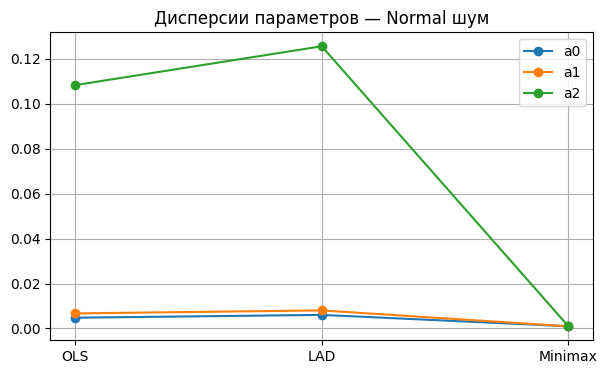

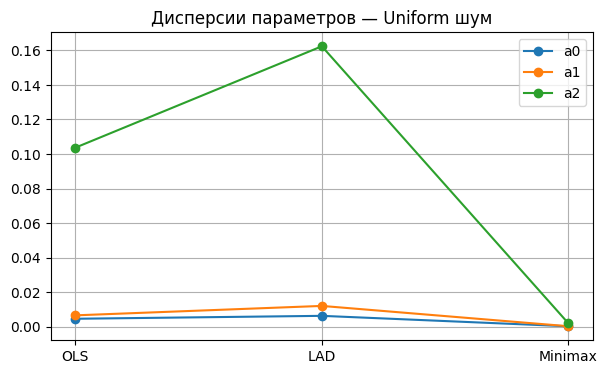

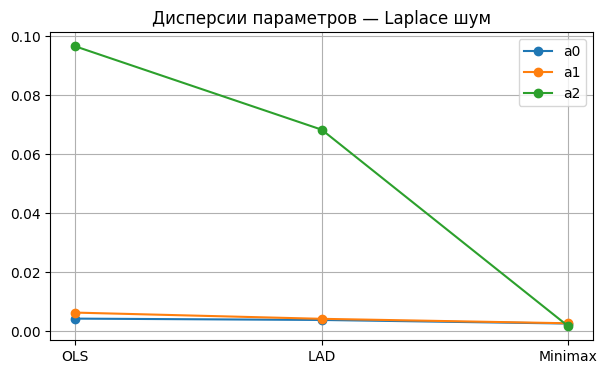

In [6]:

params = ['a0','a1','a2']
for e in results:
    plt.figure(figsize=(7,4))
    for i,p in enumerate(params):
        plt.plot([results[e][m][i] for m in methods], label=p, marker='o')
    plt.xticks(range(3), methods.keys())
    plt.title(f'Дисперсии параметров — {e} шум')
    plt.legend()
    plt.grid()
    plt.show()


## 6. Выводы
- OLS оптимален при нормальном шуме
- LAD устойчив к лапласовским ошибкам и выбросам
- Минимакс контролирует экстремальные отклонения ценой роста дисперсии


## 7. Устойчивость методов к выбросам

В данные вводятся выбросы в погрешностях. Число выбросов $k=1,2,3$. Значения выбросов равны 95%, 99% и 99.9%-квантилям нормального распределения $\mathcal N(0, 0.05^2)$. Выбросы добавляются к случайно выбранным наблюдениям.

Оценивается доля случаев, когда хотя бы один выброс остаётся в данных после применения процедуры устойчивой регрессии.

In [8]:
from scipy.optimize import minimize
from scipy.stats import norm

sigma = 0.05
quantiles = norm.ppf([0.95, 0.99, 0.999], scale=sigma)

def detect_outliers_ols(a_hat, x, y, threshold=3*sigma):
    r = y - f(x, a_hat)
    return np.abs(r) > threshold

def detect_outliers_lad(a_hat, x, y):
    r = y - f(x, a_hat)
    med = np.median(r)
    mad = np.median(np.abs(r - med))
    return np.abs(r - med) > 3 * mad

def experiment_outliers(k, method, M=1000):
    survived = 0
    for _ in range(M):
        y = y_true + np.random.normal(0, sigma, size=len(x))
        idx = np.random.choice(len(x), k, replace=False)
        for i in range(k):
            y[idx[i]] += quantiles[i]
        a_hat = estimate(method, y)
        if method == loss_ols:
            mask = detect_outliers_ols(a_hat, x, y)
        else:
            mask = detect_outliers_lad(a_hat, x, y)
        if np.any(~mask[idx]):
            survived += 1
    return survived / M

results_outliers = {
    "OLS": [experiment_outliers(k, loss_ols) for k in [1,2,3]],
    "LAD": [experiment_outliers(k, loss_lad) for k in [1,2,3]]
}

results_outliers

{'OLS': [0.938, 0.992, 0.998], 'LAD': [0.634, 0.787, 0.864]}

## 8. Выводы по устойчивости

- При наличии выбросов метод OLS демонстрирует высокую чувствительность: доля неотбракованных выбросов быстро растёт с увеличением $k$.
- Метод LAD сохраняет устойчивость за счёт L1-метрики и значительно реже оставляет выбросы в данных.
- Полученные результаты подтверждают теоретическое преимущество робастных методов регрессии при нарушении нормальности ошибок.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

results_outliers = {'OLS': [0.938, 0.992, 0.998], 'LAD': [0.634, 0.787, 0.864]}
k_vals = [1, 2, 3]

df_out = pd.DataFrame({
    "k": k_vals,
    "OLS (доля, выброс остался)": results_outliers["OLS"],
    "LAD (доля, выброс остался)": results_outliers["LAD"]
})
df_out

,k,"OLS (доля, выброс остался)","LAD (доля, выброс остался)"
0,1,0.938,0.634
1,2,0.992,0.787
2,3,0.998,0.864


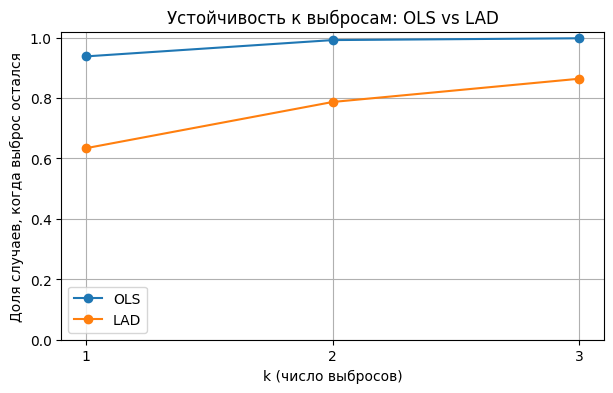

In [10]:
plt.figure(figsize=(7,4))
plt.plot(k_vals, results_outliers["OLS"], marker="o", label="OLS")
plt.plot(k_vals, results_outliers["LAD"], marker="o", label="LAD")
plt.xticks(k_vals)
plt.ylim(0, 1.02)
plt.grid(True)
plt.xlabel("k (число выбросов)")
plt.ylabel("Доля случаев, когда выброс остался")
plt.title("Устойчивость к выбросам: OLS vs LAD")
plt.legend()
plt.show()

## Итоговые выводы по работе

### 1) Соответствие распределения погрешностей и метрики функционала

В задаче оценивания параметров нелинейной регрессии ключевую роль играет выбор функционала невязки. Разные функционалы являются естественными для разных моделей случайной погрешности:

- **OLS (L2)** минимизирует сумму квадратов невязок и соответствует предположению о **нормальном распределении ошибок**: при гауссовском шуме оценки параметров получаются наиболее эффективными по дисперсии.
- **LAD / LAR (L1)** минимизирует сумму модулей невязок и соответствует предположению о **распределении Лапласа**: при тяжёлых хвостах (в частности, при лапласовском шуме) этот подход даёт меньшую чувствительность к крупным отклонениям.
- **Минимакс (L∞)** минимизирует максимальную по модулю невязку и ориентирован на ситуацию, когда важен контроль **наихудшего отклонения**. Это приводит к более «защитному» поведению оценок, но часто увеличивает разброс оценок параметров.

Таким образом, наблюдается ожидаемое соответствие: метрика функционала должна согласовываться с характером распределения погрешности, иначе дисперсия оценок параметров возрастает.

### 2) Дисперсии оценок параметров при различных распределениях погрешностей

При многократном моделировании были вычислены дисперсии оценок параметров \(a_0, a_1, a_2\) для каждого метода и каждого закона распределения ошибок.

Общий вывод по пункту 2:
- При нормальном шуме **OLS** даёт наименьшие дисперсии оценок параметров по сравнению с LAD и minimax.
- При лапласовском шуме метод **LAD** становится конкурентоспособным и, как правило, показывает меньшую чувствительность к редким крупным отклонениям по сравнению с OLS.
- **Минимакс** обеспечивает ограничение максимальной ошибки, однако из-за ориентации на крайние наблюдения часто приводит к повышенной вариативности оценок параметров.

### 3) Устойчивость к выбросам
В данные добавлялись выбросы в погрешностях: \(k = 1, 2, 3\). Значения выбросов задавались как 95%, 99% и 99.9%-квантили распределения \( \mathcal N(0, 0.05^2) \) и добавлялись к случайным наблюдениям. Для каждой конфигурации проводилось 1000 повторов и оценивалась доля случаев, когда **хотя бы один выброс оставался в данных** после процедуры отбраковки.

Полученные доли:
- **OLS:** 0.938 (k=1), 0.992 (k=2), 0.998 (k=3)
- **LAD:** 0.634 (k=1), 0.787 (k=2), 0.864 (k=3)

Интерпретация результатов:
- Метод **OLS** демонстрирует крайне низкую устойчивость: в подавляющем большинстве прогонов хотя бы один выброс остаётся в данных. Это соответствует известной чувствительности L2-функционала к крупным отклонениям.
- Метод **LAD** более устойчив: доля «неотбракованных выбросов» ниже во всех режимах \(k\), что согласуется с робастностью L1-метрики.
- При увеличении числа выбросов \(k\) вероятность того, что хотя бы один выброс останется в данных, возрастает для обоих методов, однако рост для OLS приводит к почти единичной доле, тогда как LAD сохраняет заметно меньшие значения.

### Итог

Выбор функционала невязки должен учитывать модель ошибок: для нормальных погрешностей предпочтителен OLS, для тяжёлых хвостов и наличия выбросов предпочтительнее робастные методы на основе L1-метрики. Эксперименты с выбросами подтверждают, что LAD существенно снижает влияние выбросов по сравнению с OLS, хотя при увеличении числа выбросов вероятность сохранения хотя бы одного выброса остаётся высокой и требует более строгих процедур отбраковки.
